In [16]:
import numpy as np
import os

np.random.seed(42)

import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [17]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, as_frame=False)
mnist.keys()


dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [18]:
X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

'5'

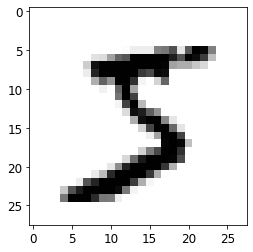

In [19]:
# EXAMPLE OF AN INSTANCE OF X AND ITS LABEL Y
plt.imshow(X[0].reshape(28, 28), cmap='binary')
y[0]

In [20]:
y = y.astype(np.uint8)
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [21]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(max_iter=1000, tol=1e-3, random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

In [9]:
some_digit = X[0]
sgd_clf.predict([some_digit])

array([ True])

In [10]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [11]:
# USING STRATIFIED K FOLD TO IMPLEMENT SOMETHING SIMILAR TO CROSS_VAL_SCORE
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(random_state=42, n_splits=3, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

    
    

0.9669
0.91625
0.96785


In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        pass
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
        
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")


array([0.91125, 0.90855, 0.90915])

In [13]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
y_train_pred

array([ True, False, False, ...,  True, False, False])

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [15]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

In [17]:
# YOU CAN USE AN f1 SCORE TO COMBINE RECALL AND PRECISION INTO ONE SCORE (USES HARMONIC MEAN, WHICH WEIGHTS LOWER
# VALUES MORE HEAVILY)

from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

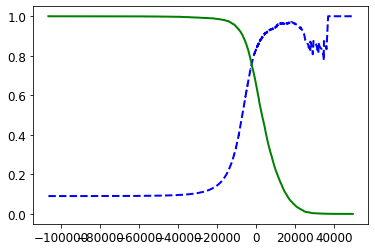

In [18]:
from sklearn.metrics import precision_recall_curve

y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)

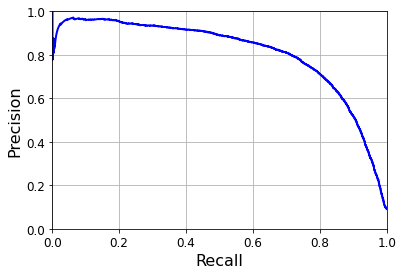

In [20]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])
    plt.grid(True)
    
plot_precision_vs_recall(precisions, recalls)

In [23]:
threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
threshold_90_precision

3370.0194991439557

In [26]:
y_train_pred_90 = (y_scores >= threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

# ROC Curves (Receiver Operating Characteristic)

ROC plots the True Positive Rate (TPR) against the False Positive Rate (FPR):

TPR is the same as recall: Out of all the actual positives, how many did you correctly identify as true positives?
TP / (TP + FN). Also known as sensitivity.

FPR is the ratio of negative instances that are incorrectly classified as positive. Equal to 1 - True Negative Rate (TNR). TNR is the ratio of negative instances correctly classified as negative. 

Text(0, 0.5, 'True Positive Rate')

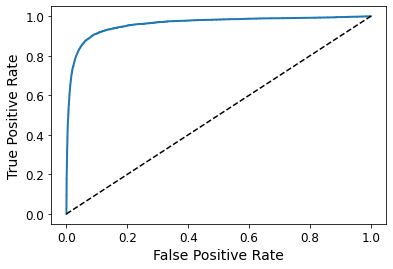

In [31]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plt.plot(fpr, tpr, linewidth=2, label=None)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

You can measure the area under the curve (AUC) as a way to determine your classifier's performance.

Use the PR Curve if the positive class is rare or you care more about false positives than false negatives, otherwise use the ROC Curve.

In [33]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42, n_estimators=100)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

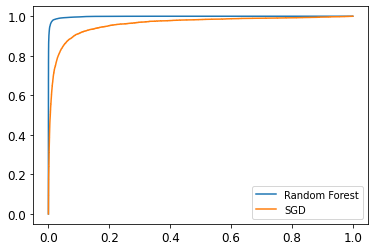

In [39]:
# SELECTING THE PROBABILITY OF THE INSTANCE BEING POSITIVE
y_scores_forest = y_probas_forest[:, 1]
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)
plt.plot(fpr_forest, tpr_forest, label="Random Forest")
plt.plot(fpr, tpr, label="SGD")
plt.legend()

In [40]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

# Multiclass Classifiers

In [15]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([X[0]])

NameError: name 'X' is not defined

In [45]:
sample_score = svm_clf.decision_function([X[0]])
sample_score
np.argmax(sample_score)

5

In [47]:
svm_clf.classes_

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

### You can force OvO or OvR by passing a classifier to the OvO or OvR constructor

In [50]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC(gamma="auto", random_state=42))
ovr_clf.fit(X_train[:1000], y_train[:1000])
ovr_clf.predict([X[0]])

array([5], dtype=uint8)

### Training an SGDClassfier on multiple classes

In [53]:
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([X[0]])

array([3], dtype=uint8)

In [54]:
sgd_clf.decision_function([X[0]])

array([[-31893.03095419, -34419.69069632,  -9530.63950739,
          1823.73154031, -22320.14822878,  -1385.80478895,
        -26188.91070951, -16147.51323997,  -4604.35491274,
        -12050.767298  ]])

In [55]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy",verbose=2)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] END .................................................... total time= 3.7min


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.7min remaining:    0.0s


[CV] END .................................................... total time= 3.8min
[CV] END .................................................... total time= 3.8min


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed: 11.4min finished


array([0.8983, 0.891 , 0.9018])

# Error Analysis

In [56]:
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

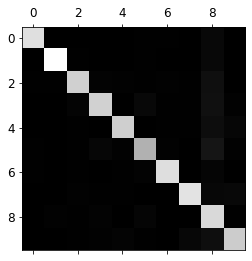

In [61]:
plt.matshow(conf_mx, cmap=plt.cm.gray)

In [63]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums


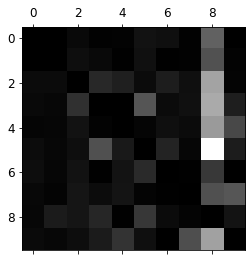

In [64]:
np.fill_diagonal(norm_conf_mx, 0)
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

# Multilabel Classification

In [66]:
# from sklearn.neighbors import KNeighborsClassifier

# y_train_large = (y_train >= 7)
# y_train_odd = (y_train % 2 == 1)
# y_multilabel = np.c_[y_train_large, y_train_odd]
# knn_clf = KNeighborsClassifier()
# knn_clf.fit(X_train, y_multilabel)

# Multilabel Multioutput Classification

In [67]:
noise = np.random.randint(0, 100, (len(X_train), 784))
X_train_mod = X_train + noise
noise = np.random.randint(0, 100, (len(X_test), 784))
X_test_mod = X_test + noise
y_train_mod = X_train
y_test_mod = X_test

In [68]:
# knn_clf.fit(X_train_mod, y_train_mod)


# Exercises

# 1: Classifier for MNIST with over 97% Accuracy

In [69]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

# param_grid = [{'weights': ["uniform", "distance"], 'n_neighbors': [3, 4, 5]}]

# knn_clf = KNeighborsClassifier()
# grid_search = GridSearchCV(knn_clf, param_grid, cv=5, verbose=3)
# grid_search.fit(X_train, y_train)

# 2: Data Augmentation

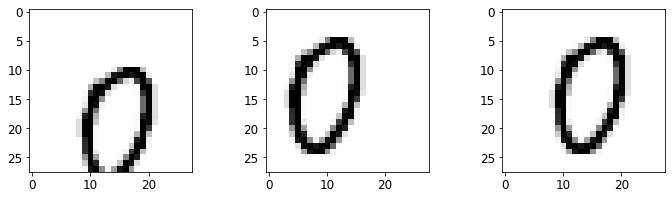

In [80]:
from scipy.ndimage.interpolation import shift

def shift_image(im_vec, dx, dy):
    im = im_vec.reshape(28, 28)
    shifted_image = shift(im, [dy, dx], cval=0, mode='constant')
    return shifted_image.reshape(-1)

image = X_train[1000]
image_shifted_down = shift_image(image, 0, 5)
image_shifted_left = shift_image(image, -5, 0)

plt.figure(figsize=(12,3))
plt.subplot(131)
plt.imshow(image_shifted_down.reshape(28, 28), cmap="Greys")
plt.subplot(132)
plt.imshow(image_shifted_left.reshape(28, 28), cmap="Greys")
plt.subplot(133)
plt.imshow(image.reshape(28, 28), cmap="Greys")
plt.show()

In [82]:
X_train.shape

(60000, 784)

In [85]:
X_train_augmented = [im for im in X_train]
y_train_augmented = [label for label in y_train]

for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1)]:
    for im, label in zip(X_train, y_train):
        X_train_augmented.append(shift_image(im, dx, dy))
        y_train_augmented.append(label)

In [87]:
X_train_augmented = np.array(X_train_augmented)
y_train_augmented = np.array(y_train_augmented)
X_train.shape, y_train.shape

((60000, 784), (60000,))

In [88]:
shuffle_idx = np.random.permutation(len(X_train_augmented))
X_train_augmented = X_train_augmented[shuffle_idx]
y_train_augmented = y_train_augmented[shuffle_idx]

In [89]:
knn_clf = KNeighborsClassifier(**grid_search.best_params_)

((300000, 784), (300000,))

In [90]:
# knn_clf.fit(X_train_augmented, y_train_augmented)

In [91]:
# y_pred = knn_clf.predict(X_test)
# accuracy_score(y_test, y_pred)

# 3: Titanic Dataset

In [22]:
import os

TITANIC_PATH = os.path.join("datasets", "titanic")

In [23]:
import pandas as pd

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

train_data.tail()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


In [24]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [25]:
for key in train_data.keys():
    print("************"+key+"************")
    print(train_data[key].value_counts())
    print("\n")

************PassengerId************
1      1
599    1
588    1
589    1
590    1
      ..
301    1
302    1
303    1
304    1
891    1
Name: PassengerId, Length: 891, dtype: int64


************Survived************
0    549
1    342
Name: Survived, dtype: int64


************Pclass************
3    491
1    216
2    184
Name: Pclass, dtype: int64


************Name************
Saalfeld, Mr. Adolphe                                  1
McMahon, Mr. Martin                                    1
Olsen, Mr. Ole Martin                                  1
LeRoy, Miss. Bertha                                    1
Pernot, Mr. Rene                                       1
                                                      ..
Coelho, Mr. Domingos Fernandeo                         1
Slayter, Miss. Hilda Mary                              1
Staneff, Mr. Ivan                                      1
Swift, Mrs. Frederick Joel (Margaret Welles Barron)    1
Thayer, Mr. John Borland                          

In [26]:
# PIPELINE FOR NUMERICAL FEATURES
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median"))
])


In [27]:
# PIPELINE FOR CATEGORICAL FEATURES
from sklearn.base import BaseEstimator, TransformerMixin

class FreqImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X], index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)
        



In [28]:
from sklearn.preprocessing import OneHotEncoder

In [29]:
cat_pipeline = Pipeline([
    ("imputer", FreqImputer()),
    ("one-hot", OneHotEncoder(sparse=False))
])

In [30]:
from sklearn.compose import ColumnTransformer

num_attribs = ["Age", "SibSp", "Parch", "Fare"]
cat_attribs = ["Pclass", "Sex", "Embarked"]

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_attribs),
    ("cat", cat_pipeline, cat_attribs)
])

In [31]:
X_train = full_pipeline.fit_transform(train_data)
X_train.shape


(891, 12)

In [32]:
y_train = train_data["Survived"]
y_train.shape

(891,)

In [33]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(gamma='auto')

In [34]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7329588014981274

### Random Forest Classifier

In [35]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8126466916354558

In [37]:
forest_clf.fit(X_train, y_train)
results = forest_clf.predict(X_train)
results.shape

(891,)

In [39]:
type(X_train)

numpy.ndarray

In [40]:
import numpy as np

In [18]:
ids = test_data["PassengerId"].to_numpy()
submit = np.c_[ids, results]

NameError: name 'np' is not defined

In [57]:
df = pd.DataFrame(submit, columns=["PassengerId", "Survived"])
final = df.to_csv('df.csv', index=False, header=True)

In [58]:
final

## Making Personal Predictor

In [15]:
svm_clf.classes_
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [16]:
X_test = full_pipeline.fit_transform(test_data)
X_test[0]


array([34.5   ,  0.    ,  0.    ,  7.8292,  0.    ,  0.    ,  1.    ,
        0.    ,  1.    ,  0.    ,  1.    ,  0.    ])

In [1]:
def generate_sample(age, sib_sp, parch, fare, pclass, sex, embarked):
    sample = [age, sib_sp, parch, fare]
    temp = [0.0] * 3
    temp[pclass-1] = 1.0
    sample.extend(temp)
    if sex == 'male':
        sample.extend([0.0, 1.0])
    elif sex == 'female':
        sample.extend([1.0, 0.0])
    if embarked == 'S':
        sample.extend([0.0, 0.0, 1.0])
    elif embarked == 'Q':
        sample.extend([0.0, 1.0, 0.0])
    elif embarked == 'C':
        sample.extend([1.0, 0.0, 0.0])
    return sample

sample = generate_sample(19.0, 1.0, 2.0, 8.05, 1, 'male', 'S')
    

In [2]:
svm_clf.predict([sample])

NameError: name 'svm_clf' is not defined

# 4: Building a Spam Classifier

In [3]:
import os
import tarfile
import urllib.request

DOWNLOAD_ROOT = "https://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url),("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        tar_bz2_file = tarfile.open(path)
        tar_bz2_file.extractall(path=spam_path)
        tar_bz2_file.close()
    
fetch_spam_data()

In [ ]:
HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
